1. Необходимо посчитать суммарное время проведенное в каждой зоне каждого пользователя (User ID) за дату в исходнике.
2. Посчитать сумму собранного товара каждым сотрудником в день.
3. Написать свой комментарий по задаче и как выходил из ситуации (показать все расчеты/формулы/ VBA скрипты).

## Изучение, преобразование данных 

Импортируем библиотеки, которые могут нам понадобиться.

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import time 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_excel('C:\\anaconda3\\Test\\Azbuka_Vkusa.xlsx', sheet_name='source')
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6818 entries, 0 to 6817
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Дата                 6818 non-null   object        
 1   Зона                 6818 non-null   object        
 2   Товар                6818 non-null   object        
 3   Количество           6818 non-null   float64       
 4   Тип операции         6818 non-null   object        
 5   User ID              6818 non-null   object        
 6   Дата время операции  6818 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 373.0+ KB


,Дата,Зона,Товар,Количество,Тип операции,User ID,Дата время операции
0,2022-05-11 00:00:00.000,F2,ТОВ287107,1.518,WMS-СБОР,IVMAKAROV,2022-05-11 14:09:10
1,2022-05-11 00:00:00.000,F2,ТОВ471470,1.000,WMS-СБОР,IVMAKAROV,2022-05-11 14:09:28
2,2022-05-11 00:00:00.000,S,ТОВ376352,1.000,WMS-СБОР,RBOBIEV,2022-05-11 14:09:30
3,2022-05-11 00:00:00.000,F,ТОВ369929,1.000,WMS-СБОР,IVMAKAROV,2022-05-11 14:09:48
4,2022-05-11 00:00:00.000,S,ТОВ404047,1.000,WMS-СБОР,RBOBIEV,2022-05-11 14:09:54


Переименую названия столбцов - с латиницей удобнее работать (меньше переключений языка). 

In [3]:
df.columns=['date','zone','goods','qty','activity','user_id','activity_time']

Изменяю тип данных, чтобы с ними было удобнее работать + они занимали меньше памяти. 

In [4]:
df['qty'] = df['qty'].astype('float')
df['date'] = pd.DatetimeIndex(df['date']).day

На всякий случай, проверил датасет на наличие дубликатов. 

In [5]:
print('Дубликатов в таблице:', df.duplicated().sum())

Дубликатов в таблице: 0


In [6]:
display(df.sort_values(['user_id', 'activity_time']).head())

,date,zone,goods,qty,activity,user_id,activity_time
1061,11,S2,ТОВ490874,2.0,WMS-ИНВЕНТ,AABELOUSOV,2022-05-11 23:45:04
3827,12,S,ТОВ142564,2.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:56:03
3828,12,S2,ТОВ311091,5.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:34
3829,12,S2,ТОВ333255,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:47
3833,12,S,ТОВ443733,7.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:59:37


На текущем этапе видно 2 пути решения задачи: 

1. Искать среднее время одной операции и экстраполировать на весь датасет.
2. Найти время, проведенное оператором в одной зоне с момента первой отметки времени до последней отметки времени. 

Мы пойдем по второму пути, так как число операторов и их эффективность могут разниться.
Для этого мы отсортируем датасет по оператору и дате операции. 

In [7]:
df = df.sort_values(['user_id', 'activity_time'])

In [8]:
display(df)

,date,zone,goods,qty,activity,user_id,activity_time
1061,11,S2,ТОВ490874,2.000,WMS-ИНВЕНТ,AABELOUSOV,2022-05-11 23:45:04
3827,12,S,ТОВ142564,2.000,WMS-СБОР,AKHMANAPOV,2022-05-12 20:56:03
3828,12,S2,ТОВ311091,5.000,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:34
3829,12,S2,ТОВ333255,1.000,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:47
3833,12,S,ТОВ443733,7.000,WMS-СБОР,AKHMANAPOV,2022-05-12 20:59:37
...,...,...,...,...,...,...,...
6775,13,F,ТОВ264788,1.000,WMS-СБОР,SSHARIPOV,2022-05-13 13:11:02
330,11,F,ТОВ244765,1.614,WMS-СБОР,VLKONONOV,2022-05-11 17:18:11
332,11,F,ТОВ355543,1.000,WMS-СБОР,VLKONONOV,2022-05-11 17:20:25
339,11,FT,ТОВ434125,1.000,WMS-СБОР,VLKONONOV,2022-05-11 17:22:10


Здесь мы циклом пройдем по каждой паре строк и обозначим моменты, когда меняется либо дата, либо оператор, либо зона работы.  

In [9]:
index=df.index.tolist()

list=[]

for x in range(len(index)):
    
    if x == (len(index)-1):
        list.append(True)
    else:
        if (df.loc[index[x]]['date'] != df.loc[index[x+1]]['date'] 
            or df.loc[index[x]]['zone'] != df.loc[index[x+1]]['zone'] 
            or df.loc[index[x]]['user_id'] != df.loc[index[x+1]]['user_id']):
            list.append(True)
        else:
            list.append(False)
        

В колонке **check** мы теперь видим, когда оператор находится внутри зоны в конкретный день (False), а когда он переходит в другую зону/ меняется оператор/ дата.  

In [10]:
df['check'] = list

print(list[:10])
df.head(10)

[True, True, False, True, False, False, True, True, False, False]


,date,zone,goods,qty,activity,user_id,activity_time,check
1061,11,S2,ТОВ490874,2.0,WMS-ИНВЕНТ,AABELOUSOV,2022-05-11 23:45:04,True
3827,12,S,ТОВ142564,2.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:56:03,True
3828,12,S2,ТОВ311091,5.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:34,False
3829,12,S2,ТОВ333255,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:47,True
3833,12,S,ТОВ443733,7.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:59:37,False
3836,12,S,ТОВ461100,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:03,False
3839,12,S,ТОВ443733,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:39,True
3840,12,S2,ТОВ430483,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:56,True
3841,12,S,ТОВ167753,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:01:10,False
3843,12,S,ТОВ318905,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:01:27,False


Далее мы работаем только с той частью датасета, где происходили "переходы"

In [11]:
df_new = df.query('check == True')
display(df_new.head())
len(df_new)

,date,zone,goods,qty,activity,user_id,activity_time,check
1061,11,S2,ТОВ490874,2.0,WMS-ИНВЕНТ,AABELOUSOV,2022-05-11 23:45:04,True
3827,12,S,ТОВ142564,2.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:56:03,True
3829,12,S2,ТОВ333255,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:47,True
3839,12,S,ТОВ443733,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:39,True
3840,12,S2,ТОВ430483,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:56,True


1066

Мы находим разницу между соседними датой-временем, когда осуществляется переход в другую зону/ к другому оператору/ дате. 

In [12]:
index=df_new.index.tolist()

list=[]

for x in range(len(index)):
    
    if x == (len(index)-1):
        list.append(True)
    else:
        if (df_new.loc[index[x]]['date'] == df_new.loc[index[x+1]]['date'] 
            and df_new.loc[index[x]]['zone'] != df_new.loc[index[x+1]]['zone'] 
            and df_new.loc[index[x]]['user_id'] == df_new.loc[index[x+1]]['user_id']):
            list.append((df_new.loc[index[x+1]]['activity_time'] - df_new.loc[index[x]]['activity_time']).seconds)
        else:
            list.append(0)

df_new['seconds'] = list

display(df_new.head())



C:\Users\A11C~1\AppData\Local\Temp/ipykernel_12796/653926950.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['seconds'] = list


,date,zone,goods,qty,activity,user_id,activity_time,check,seconds
1061,11,S2,ТОВ490874,2.0,WMS-ИНВЕНТ,AABELOUSOV,2022-05-11 23:45:04,True,0
3827,12,S,ТОВ142564,2.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:56:03,True,104
3829,12,S2,ТОВ333255,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:47,True,172
3839,12,S,ТОВ443733,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:39,True,17
3840,12,S2,ТОВ430483,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:56,True,342


In [13]:
print(len(df_new.query('seconds > 0')))

1044


Все промежуточные операции нам неинтересны, так как они входят в диапазоны времени, которые мы посчитали. 

In [14]:
len(df_new[['date','user_id']].drop_duplicates())

23

Осталось 23 "пробела" - строки, для которых нет возможности проставить разницу (например, единичная операция в другой зоне склада с последующим возвратом в исходную). Чтобы заполнить пропуски, мы посчитаем среднее 

In [15]:
df = df.drop(columns=['check'])
index=df.index.tolist()

list=[]

for x in range(len(index)):
    
    if x == (len(index)-1):
        list.append(True)
    else:
        if (df.loc[index[x]]['date'] == df.loc[index[x+1]]['date'] 
            and df.loc[index[x]]['zone'] == df.loc[index[x+1]]['zone'] 
            and df.loc[index[x]]['user_id'] == df.loc[index[x+1]]['user_id']
            and df.loc[index[x]]['activity'] == df.loc[index[x+1]]['activity']):
            list.append((df.loc[index[x+1]]['activity_time'] - df.loc[index[x]]['activity_time']).seconds)
        else:
            list.append(0)

df['common_activity_seconds'] = list

display(df.head())

,date,zone,goods,qty,activity,user_id,activity_time,common_activity_seconds
1061,11,S2,ТОВ490874,2.0,WMS-ИНВЕНТ,AABELOUSOV,2022-05-11 23:45:04,0
3827,12,S,ТОВ142564,2.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:56:03,0
3828,12,S2,ТОВ311091,5.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:34,13
3829,12,S2,ТОВ333255,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:47,0
3833,12,S,ТОВ443733,7.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:59:37,26


Для вычисления среднего значения времени на операцию уберем из датасета операции, которые не подошли условию выше, а потому обозначены в common_activity_seconds нулем. Получим вспомогательную таблицу со среднем временем на операцию в зависимости от ее типа. 

In [16]:
df = df.query('common_activity_seconds > 0')

df_support = df.pivot_table(index='activity', values='common_activity_seconds', aggfunc='mean')

display(df_support)

,common_activity_seconds
activity,
WMS-ИНВЕНТ,44.160714
WMS-СБОР,42.913510


Время на обе операции практически идентично, поэтому можем заменить 23 пропуска во вспомогательном датасете df_new средним значением. Добавим колонку с минутами (для наглядности).

In [17]:
df_new['seconds'] = df_new['seconds'].replace(to_replace =0, value =df['common_activity_seconds'].mean())
df_new['minutes'] = df_new['seconds']/60

display(df_new.head())

,date,zone,goods,qty,activity,user_id,activity_time,check,seconds,minutes
1061,11,S2,ТОВ490874,2.0,WMS-ИНВЕНТ,AABELOUSOV,2022-05-11 23:45:04,True,42.974873,0.716248
3827,12,S,ТОВ142564,2.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:56:03,True,104,1.733333
3829,12,S2,ТОВ333255,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 20:57:47,True,172,2.866667
3839,12,S,ТОВ443733,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:39,True,17,0.283333
3840,12,S2,ТОВ430483,1.0,WMS-СБОР,AKHMANAPOV,2022-05-12 21:00:56,True,342,5.7


## Время операторов по зонам по датам

In [18]:
df_summary = df_new.pivot_table(index=['date','user_id','zone'], values='minutes', aggfunc='sum')
pd.set_option('display.max_rows', None)
display(df_summary)

minutes
date user_id    zone            
11   AABELOUSOV S2      0.716248
     ARYABTSEV  Z       0.716248
     AUNAISAROV F      19.566667
                F2     76.599581
                S      27.350000
                S2     49.583333
     IVMAKAROV  F     100.800000
                F2     83.516667
                S     168.766248
                S2     19.566667
     RBOBIEV    F      69.016667
                F2     84.166667
                FT     19.216667
                S      61.232915
                S2    113.300000
     VLKONONOV  F       1.750000
                FT      5.000000
                S2      0.016667
12   AKHMANAPOV F      27.216667
                F2     59.016667
                S      38.332915
                S2     47.883333
     ALELEBEDEV F      20.116248
                F2     46.116667
                S      74.883333
                S2     41.283333
     ARPLATONOV F      47.366667
                F2     11.033333
                FT      9.750000
                S      31.216667
                S2     75.216248
     AUNAISAROV F     134.216248
                F2    133.200000
                FT     43.100000
                S      79.266667
                S2    129.316667
     KAKHMEDOV  F     142.750000
                F2    129.316667
                FT     54.433333
                S     130.449581
                S2    167.666667
     MKOSTENKO  F     462.233333
                F2     42.316667
                Z      66.699581
     RATAEV     F      23.166248
                S     187.966667
                S2    297.500000
                Z     106.083333
     SRASKHODCH F2      0.716248
     SSHARIPOV  F     116.149581
                F2    346.383333
                FT     45.833333
                S      71.866667
                S2     77.633333
13   AKHMANAPOV F     116.733333
                F2    126.133333
                FT     66.033333
                S      78.349581
                S2     91.200000
     ALELEBEDEV F     136.149581
                F2    226.516667
                FT     38.483333
                S      35.783333
                S2     62.533333
     ARPLATONOV F      76.299581
                F2    271.050000
                FT     73.783333
                S      53.900000
                S2     32.000000
     ASIRENKO   F      45.000000
                S     176.966667
                S2      0.716248
     KAKHMEDOV  F      37.033333
                F2     87.933333
                FT     19.050000
                S      62.782915
                S2     49.000000
     MKOSTENKO  Z       0.716248
     RATAEV     F       0.716248
                S2     24.950000
     SSHARIPOV  F      58.432915
                F2     69.916667
                FT     18.683333
                S      33.616667
                S2     65.883333

Построим графики для визуализации полученных результатов. 

Text(0, 0.5, 'Minutes')

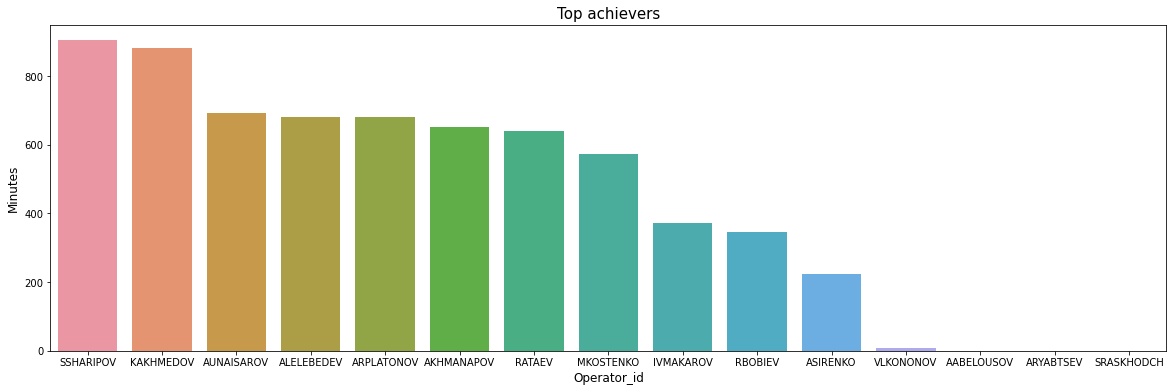

In [19]:
top_achievers = df_new.pivot_table(index='user_id', values='minutes', aggfunc='sum').sort_values(
    by='minutes', ascending=False).reset_index().rename_axis(None, axis=1)
 
plt.figure(figsize=(20,6))
plt.title('Top achievers',fontsize=15)
sns.barplot(data=top_achievers, x='user_id', y='minutes')
plt.xlabel('Operator_id',fontsize=12)
plt.ylabel('Minutes',fontsize=12)

Операторы SSHARIPOV и KAKHMEDOV значительно операжают остальных операторов по времени, проведенному в зонах склада. 
Операторы AABELOUSOV, ARYABTSEV, SRASKHODCH провели на складе наименьшее число времени в зонах, в которых были сделаны отметки времени операции. 

## Количество собранного товара каждым оператором в день. 

In [20]:
df_sum_goods = df_new.pivot_table(index=['date','user_id'], values='qty', aggfunc='sum')
pd.set_option('display.max_rows', None)
display(df_sum_goods)

qty
date user_id            
11   AABELOUSOV    2.000
     ARYABTSEV    72.000
     AUNAISAROV  110.000
     IVMAKAROV    48.338
     RBOBIEV     130.896
     VLKONONOV     3.000
12   AKHMANAPOV   74.064
     ALELEBEDEV   58.904
     ARPLATONOV  111.754
     AUNAISAROV  175.734
     KAKHMEDOV   201.796
     MKOSTENKO    31.994
     RATAEV       97.000
     SRASKHODCH   12.460
     SSHARIPOV   248.923
13   AKHMANAPOV  192.880
     ALELEBEDEV  108.622
     ARPLATONOV   84.709
     ASIRENKO      5.000
     KAKHMEDOV    94.976
     MKOSTENKO     2.000
     RATAEV        2.000
     SSHARIPOV   118.919

Также проверим уровень загрузки каждой зоны склада.

Text(0, 0.5, 'Minutes')

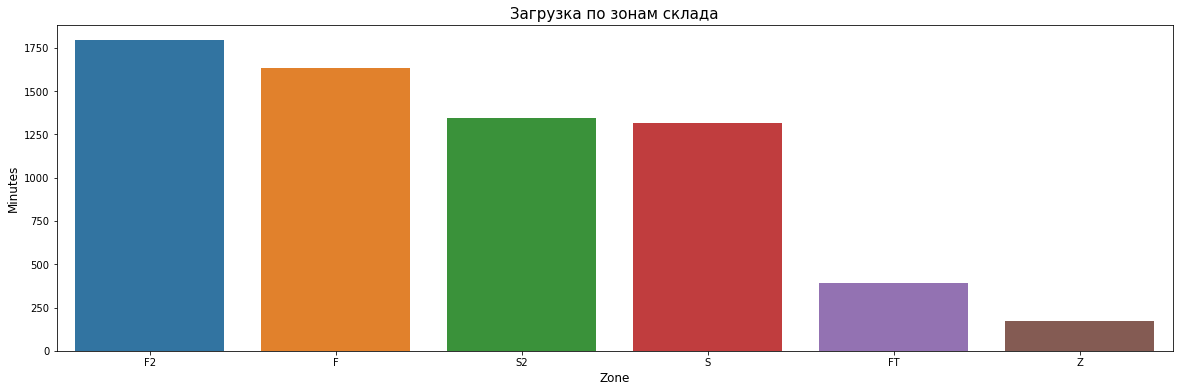

In [21]:
top_zones = df_new.pivot_table(index='zone', values='minutes', aggfunc='sum').sort_values(
    by='minutes', ascending=False).reset_index().rename_axis(None, axis=1)
 
plt.figure(figsize=(20,6))
plt.title('Загрузка по зонам склада',fontsize=15)
sns.barplot(data=top_zones, x='zone', y='minutes')
plt.xlabel('Zone',fontsize=12)
plt.ylabel('Minutes',fontsize=12)

В зоне склада F2 и F операторы проводят больше всего времени, при этом в зонах FT и Z - наименьшее. 

Проверим загрузку склада по дням. 

Text(0, 0.5, 'Minutes')

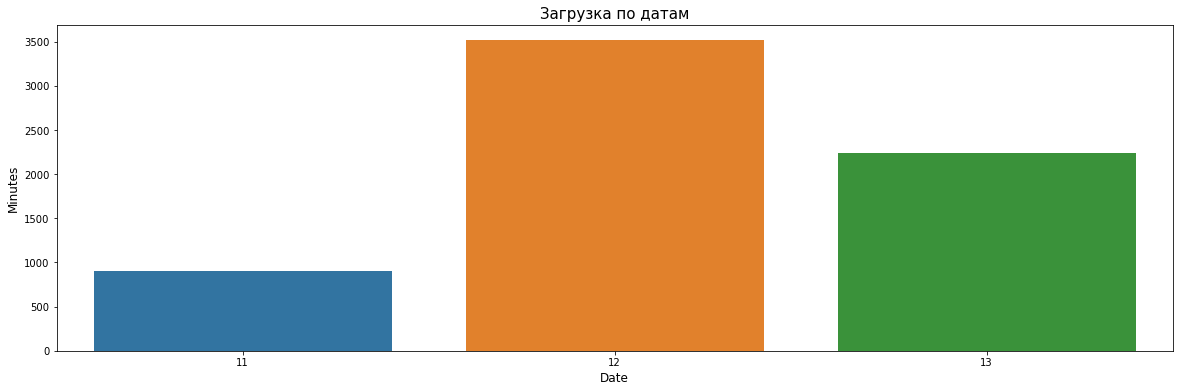

In [22]:
top_dates = df_new.pivot_table(index='date', values='minutes', aggfunc='sum').sort_values(
    by='minutes', ascending=False).reset_index().rename_axis(None, axis=1)
 
plt.figure(figsize=(20,6))
plt.title('Загрузка по датам',fontsize=15)
sns.barplot(data=top_dates, x='date', y='minutes')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Minutes',fontsize=12)

12 мая склад был загружен значительно больше, чем 11 и 13 мая. Это может быть связано с работой склада после выхода с майских праздников. 

## Обратить внимание

(0.0, 200.0)

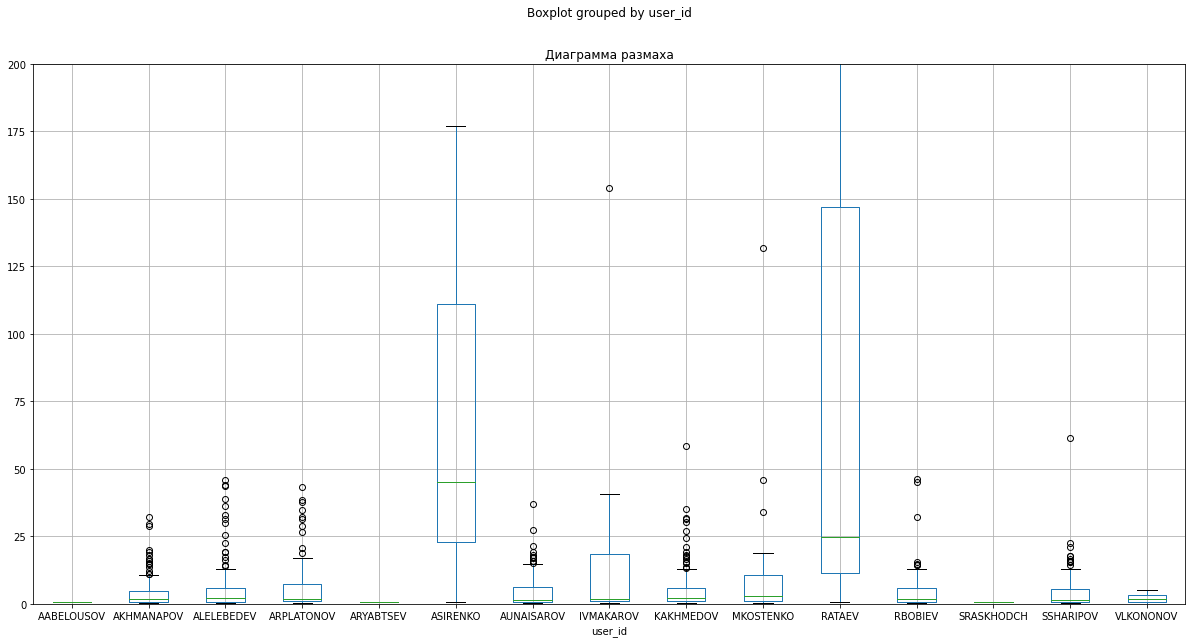

In [23]:
(
    df_new.boxplot ('minutes',by='user_id', figsize = (20,10))
    .set_title('Диаграмма размаха')
)
plt.ylim(0,200)

Обратим внимание: ASIRENKO и RATAEV имеют значительный разброс времени, проведенной в одной зоне, не будучи лидерами по суммарному времени, проведенному за выполнением операций. Из чего можно предположить, что операторы были вынуждены часто перемещаться между зонами, что может снизить эффективность их работы. 